In [37]:
from src.features.build_features import get_roast_classification_dataset, get_vocab
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import logser
from keras.preprocessing.text import Tokenizer
from random import randint
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
from bokeh.io import output_file, show
from bokeh.plotting import figure

## Model 1

* Read in 'blind_assessment' text
* Define vocab as all words that show up >5 times
* Tokenize the text.
* Integer encode the tokens
* Convert sentences to word count/frequency vectors.  Length of vector = vocab size.
* Feed vectors into a random forest model
* 40% of the training examples are classified as medium-light.  So 40% is the number to beat.

In [2]:
X, y = get_roast_classification_dataset()

In [3]:
# Split into test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [4]:
# generate the vocab list from only the TRAINING dataset
vocab = get_vocab(X_train, min_count=5)

In [5]:
# create tokenizer
t = Tokenizer(lower=True, split=' ')
# fit on vocab list
t.fit_on_texts(vocab)
# convert x_train and x_test to word count vectors
X_train = t.texts_to_matrix(X_train, mode='count')
X_test = t.texts_to_matrix(X_test, mode='count')

In [6]:
# Fit model, and make predictions
rnd_clf = RandomForestClassifier(n_estimators=500, max_depth=16, n_jobs=-1, oob_score=True, random_state=21)
rnd_clf.fit(X_train, y_train)

In [7]:
rnd_clf.oob_score_

0.5251558325912734

In [8]:
# maybe grid search over hyperparameters, or random search
# TODO - EDA of how evenly are the classes are distributed
# TODO - how can I tell which words are associated with each class?  Like a clustering thing? (maybe naive bayes?)
# TODO - Test model on test set
# TODO - maybe look at the decision tree of a single tree

## Hyperparameter Tuning

### Tune the Max Depth

Once you get to a max depth of about 30, there doesn't seem to be an improvement in the out of bag evaluation score.

In [9]:
y_oob_score = []
for max_depth in range(1, 64):
    rnd_clf = RandomForestClassifier(n_estimators=500, max_depth=max_depth, n_jobs=-1, oob_score=True, random_state=21)
    rnd_clf.fit(X_train, y_train)
    y_oob_score.append(rnd_clf.oob_score_)

In [11]:
# Plot OOB score as a function of max depth
from bokeh.plotting import figure, show
from bokeh.io import push_notebook, show, output_notebook
from bokeh.resources import INLINE

output_notebook(resources=INLINE)

x_max_depth = list(range(1, 64))
#y_oob_score = stats
# create a new plot with a title and axis labels
p = figure(title="OOB Score as a Function of Max Depth", x_axis_label='Max Depth', y_axis_label='OOB Score')
# add a line renderer with legend and line thickness to the plot
p.line(x_max_depth, y_oob_score, line_width=2)
# show the results
show(p)

Loading BokehJS ...

### Tune the Number of Estimators

Once you get to about 2500 estimators, there doesn't seem to be much further improvement in the OOB score.

In [12]:
y_oob_score = []
for n_estimators in [50, 100, 250, 500, 1000, 2500, 5000, 10000]:
    rnd_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=32, n_jobs=-1, oob_score=True, random_state=21)
    rnd_clf.fit(X_train, y_train)
    y_oob_score.append(rnd_clf.oob_score_)

In [13]:
x_num_estimators = [50, 100, 250, 500, 1000, 2500, 5000, 10000]
# create a new plot with a title and axis labels
p = figure(title="OOB Score as a Function of # of Trees", x_axis_label='Number of Trees', y_axis_label='OOB Score')
# add a line renderer with legend and line thickness to the plot
p.line(x_num_estimators, y_oob_score, line_width=2)
# show the results
show(p)

### Tune the Number of Features Used

The best model has about 250 features.

In [14]:
y_oob_score = []
for n_features in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    rnd_clf = RandomForestClassifier(n_estimators=2500, max_depth=32, max_features=n_features, n_jobs=-1, oob_score=True, random_state=21)
    rnd_clf.fit(X_train, y_train)
    y_oob_score.append(rnd_clf.oob_score_)

In [15]:
x_num_features = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
# create a new plot with a title and axis labels
p = figure(title="OOB Score as a Function of # Features Used", x_axis_label='Number of Features', y_axis_label='OOB Score')
# add a line renderer with legend and line thickness to the plot
p.line(x_num_features, y_oob_score, line_width=2)
# show the results
show(p)

### Try a random search

In [17]:
rnd_clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=21)
param_dist = {"max_depth": [1, 10, 100, 1000],
              "n_estimators": [50, 100, 1000],
              "max_features": [1, 10, 100, 1000],
              "min_samples_split": [2, 3, 5, 7, 9],
              "bootstrap": [True]}
n_iter_search = 30
random_search = RandomizedSearchCV(rnd_clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, random_state=21,
                                  return_train_score=True)
random_search.fit(X_train, y_train)


RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                                    random_state=21),
                   n_iter=30,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [1, 10, 100, 1000],
                                        'max_features': [1, 10, 100, 1000],
                                        'min_samples_split': [2, 3, 5, 7, 9],
                                        'n_estimators': [50, 100, 1000]},
                   random_state=21, return_train_score=True)

In [18]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.557 (std: 0.026)
Parameters: {'n_estimators': 1000, 'min_samples_split': 9, 'max_features': 100, 'max_depth': 100, 'bootstrap': True}

Model with rank: 2
Mean validation score: 0.554 (std: 0.022)
Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_features': 100, 'max_depth': 100, 'bootstrap': True}

Model with rank: 3
Mean validation score: 0.554 (std: 0.024)
Parameters: {'n_estimators': 1000, 'min_samples_split': 5, 'max_features': 100, 'max_depth': 100, 'bootstrap': True}



### Round 2.  Finer Search

In [19]:
rnd_clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=21)
param_dist = {"max_depth": [50, 75, 100, 250, 500],
              "n_estimators": [500, 750, 1000, 1250, 1500, 2000],
              "max_features": [50, 75, 100, 250, 500],
              "min_samples_split": [2, 3, 5, 7, 9],
              "bootstrap": [True]}
n_iter_search = 30
random_search = RandomizedSearchCV(rnd_clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, random_state=21,
                                  return_train_score=True)
random_search.fit(X_train, y_train)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.558 (std: 0.023)
Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_features': 250, 'max_depth': 75, 'bootstrap': True}

Model with rank: 2
Mean validation score: 0.558 (std: 0.022)
Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'max_features': 250, 'max_depth': 250, 'bootstrap': True}

Model with rank: 3
Mean validation score: 0.558 (std: 0.023)
Parameters: {'n_estimators': 1000, 'min_samples_split': 5, 'max_features': 250, 'max_depth': 50, 'bootstrap': True}



## Examine Feature Importances

### First train a model with the best hyperparameters

In [20]:
rnd_clf = RandomForestClassifier(n_estimators=1000, max_depth=32, max_features=250, n_jobs=-1, oob_score=True, random_state=21)
rnd_clf.fit(X_train, y_train)
rnd_clf.oob_score_

0.5576580587711487

### Map Feature Importances to the Right Words

In [21]:
importances = rnd_clf.feature_importances_
feature_index = ast.literal_eval(t.get_config()['index_word'])

In [22]:
from collections import OrderedDict
word_importance = OrderedDict()

for k, word in feature_index.items():
    feature_idx = int(k)
    word_importance[word] = importances[feature_idx]

In [23]:
word_importance_sorted = sorted(word_importance.items(), key=lambda t: t[1], reverse=True)

In [24]:
word_importance_sorted

[('structure', 0.027206623848993396),
 ('mouthfeel', 0.024985001699907045),
 ('acidity', 0.018751455671831313),
 ('roast', 0.017092588030908497),
 ('the', 0.014395323805922875),
 ('a', 0.012876035009015744),
 ('chocolate', 0.011632547969155346),
 ('and', 0.010962221363603053),
 ('tart', 0.009600976484707334),
 ('juicy', 0.009077292860625717),
 ('scorched', 0.008653335682342457),
 ('in', 0.008424527825611924),
 ('roasty', 0.008262391444459177),
 ('sweet', 0.008129372309432692),
 ('but', 0.007948697472155437),
 ('of', 0.007157521218366876),
 ('with', 0.00706421980606629),
 ('as', 0.005951738136717666),
 ('fruit', 0.00592491962509135),
 ('finish', 0.005828884950821784),
 ('toned', 0.00581358710723163),
 ('notes', 0.005781174956732901),
 ('dark', 0.005747971381884837),
 ('ounce', 0.005489051061615669),
 ('brewed', 0.005341380214919148),
 ('flowers', 0.005159111187115397),
 ('sweetly', 0.005148712207758938),
 ('milk', 0.0050993589363845584),
 ('device', 0.005045459700891916),
 ('nib', 0.005

In [28]:
# only look at top 50
x_word = []
y_importance = []
for word, importance in word_importance_sorted:
    x_word.append(word)
    y_importance.append(importance)
    
x_word = x_word[0:50]
y_importance = y_importance[0:50]

In [29]:
p = figure(x_range=x_word, plot_height=500, plot_width=900, title="Word Importance",
           toolbar_location=None, tools="")
p.vbar(x=x_word, top=y_importance, width=0.9)
p.xgrid.grid_line_color = None
p.y_range.start = 0
p.xaxis.major_label_orientation = "vertical"

show(p)

## Learning Curve

Would adding more data improve the accuracy of my model?

I don't think adding more data would improve the accuracy of this model.  Once you get to about 2000 training examples, the accuracy of the model stops improving.

In [31]:
training_set_size = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1300, 1400, 1600, 1800, 2000, 2500, 3000, 3500]


train_sizes, train_scores, test_scores, fit_times, _  = learning_curve(
    estimator=RandomForestClassifier(n_estimators=500, max_depth=32, max_features=250, n_jobs=-1, oob_score=True, random_state=21),
    X=X_train,
    y=y_train,
    train_sizes=training_set_size,
    cv=5,
    shuffle=True,
    n_jobs=-1,
    random_state=21,
    return_times=True)

In [34]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

Text(0.5, 1.0, 'Performance of the model')

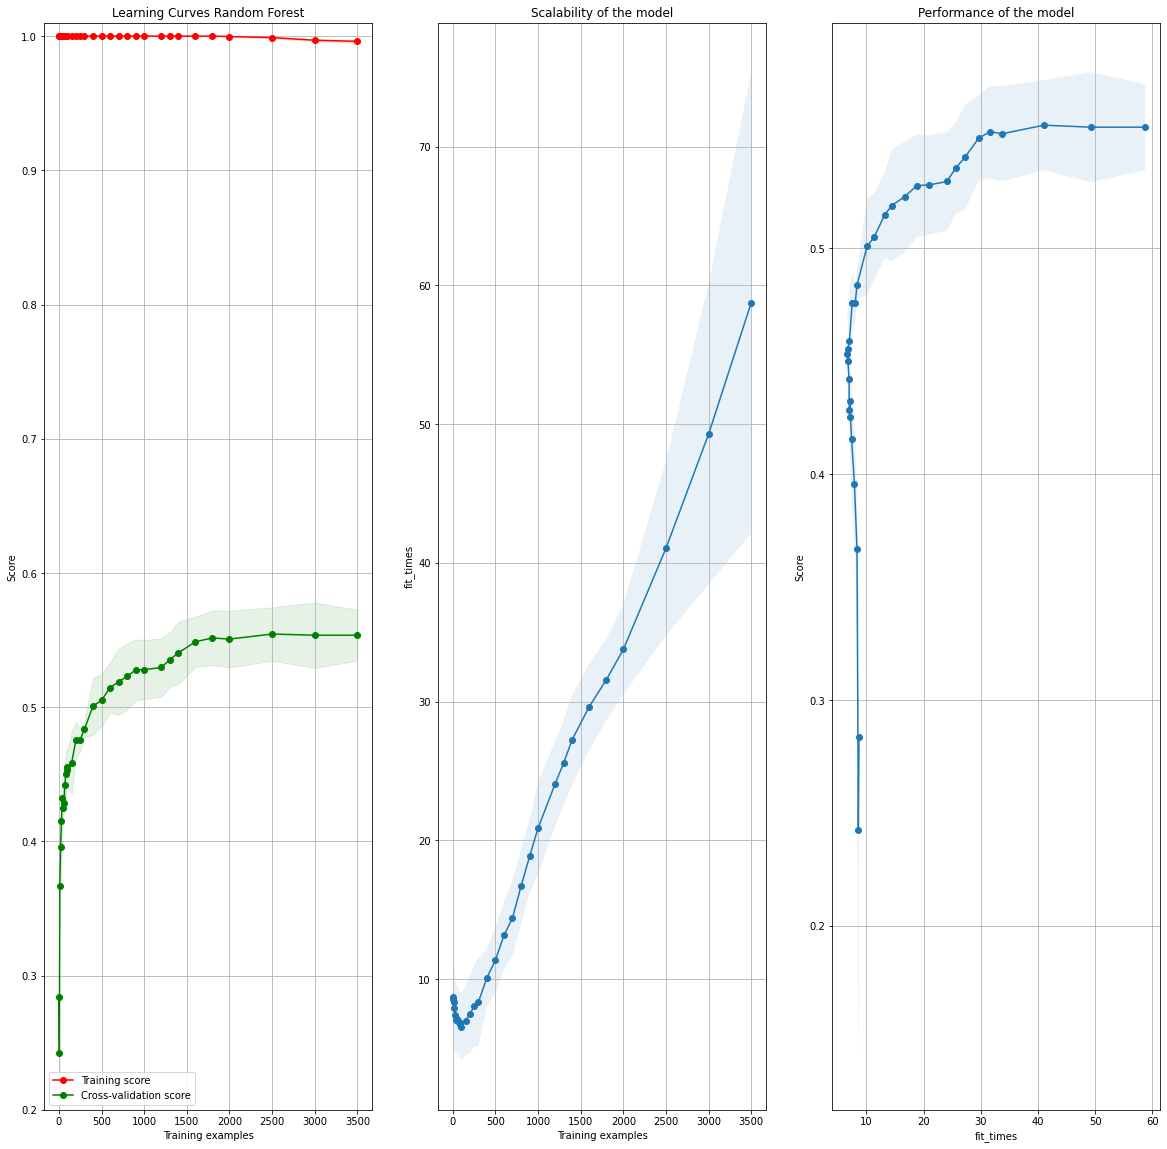

In [38]:
# Plot learning curve
_, axes = plt.subplots(1, 3, figsize=(20, 20))

if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].set_title("Learning Curves Random Forest")
axes[0].set_ylim(*(0.20, 1.01))
axes[0].set_xlabel("Training examples")
axes[0].set_ylabel("Score")

axes[0].grid()
axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
axes[0].legend(loc="best")

# Plot n_samples vs fit_times
axes[1].grid()
axes[1].plot(train_sizes, fit_times_mean, 'o-')
axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                     fit_times_mean + fit_times_std, alpha=0.1)
axes[1].set_xlabel("Training examples")
axes[1].set_ylabel("fit_times")
axes[1].set_title("Scalability of the model")

# Plot fit_time vs score
axes[2].grid()
axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
axes[2].set_xlabel("fit_times")
axes[2].set_ylabel("Score")
axes[2].set_title("Performance of the model")

# Scratch

In [39]:
#training_set_size = list(range(100, 4500, 100))
training_set_size = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 400, 500, 1000, 2000, 3000]


train_sizes, train_scores, test_scores, fit_times, _  = learning_curve(
    estimator=RandomForestClassifier(n_estimators=500, max_depth=5, max_features=250, n_jobs=-1, oob_score=True, random_state=21),
    X=X_train,
    y=y_train,
    train_sizes=training_set_size,
    cv=5,
    shuffle=True,
    n_jobs=-1,
    random_state=21,
    return_times=True)

In [40]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

Text(0.5, 1.0, 'Performance of the model')

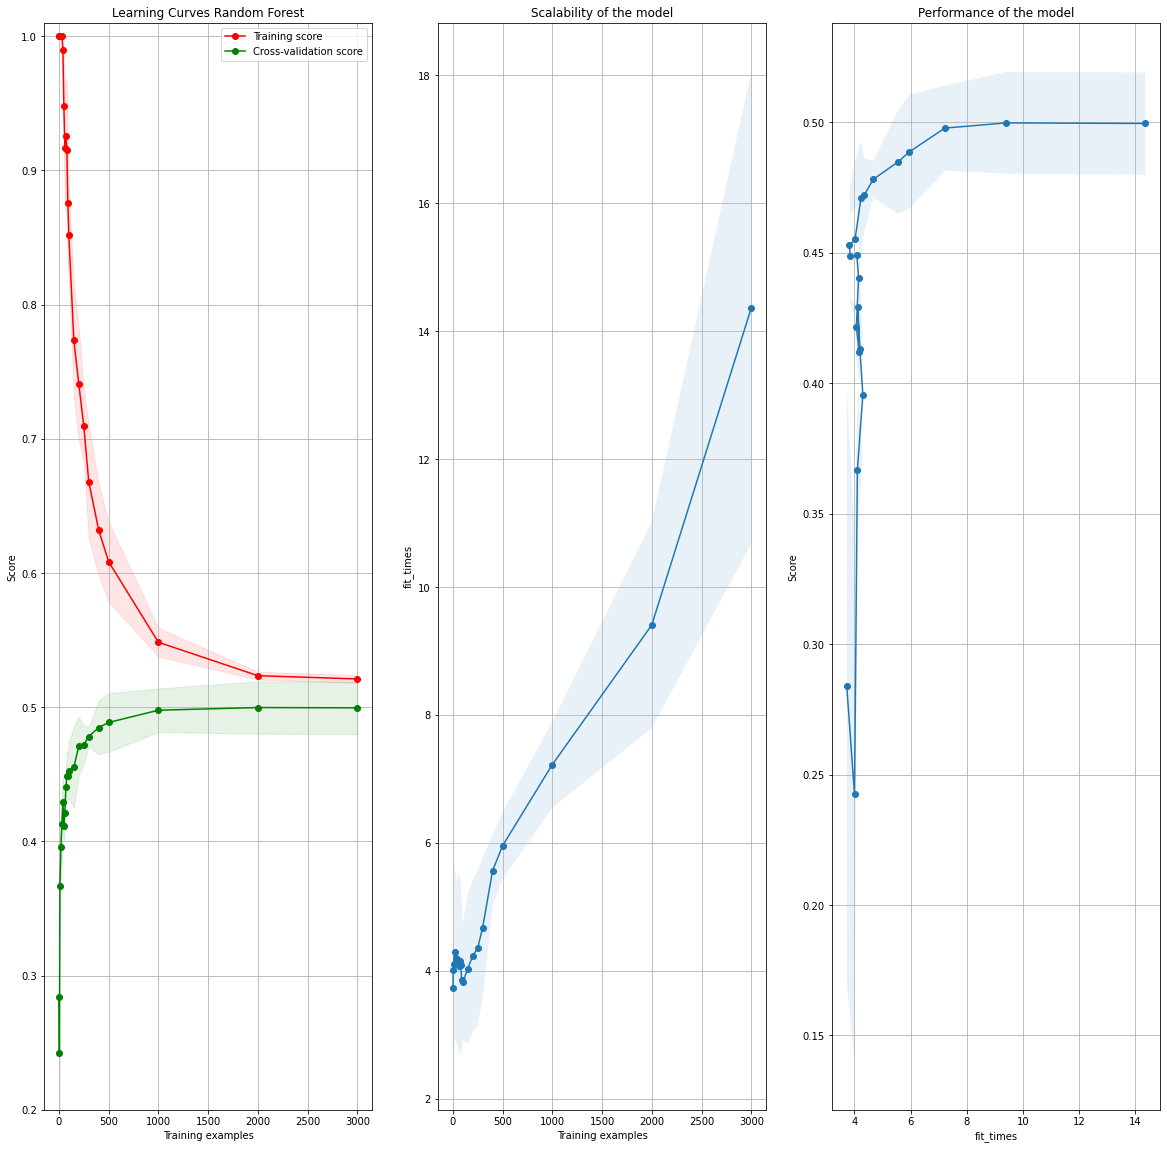

In [41]:
# Plot learning curve
_, axes = plt.subplots(1, 3, figsize=(20, 20))

if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].set_title("Learning Curves Random Forest")
axes[0].set_ylim(*(0.20, 1.01))
axes[0].set_xlabel("Training examples")
axes[0].set_ylabel("Score")

axes[0].grid()
axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
axes[0].legend(loc="best")

# Plot n_samples vs fit_times
axes[1].grid()
axes[1].plot(train_sizes, fit_times_mean, 'o-')
axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                     fit_times_mean + fit_times_std, alpha=0.1)
axes[1].set_xlabel("Training examples")
axes[1].set_ylabel("fit_times")
axes[1].set_title("Scalability of the model")

# Plot fit_time vs score
axes[2].grid()
axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
axes[2].set_xlabel("fit_times")
axes[2].set_ylabel("Score")
axes[2].set_title("Performance of the model")

Text(0.5, 1.0, 'Performance of the model')

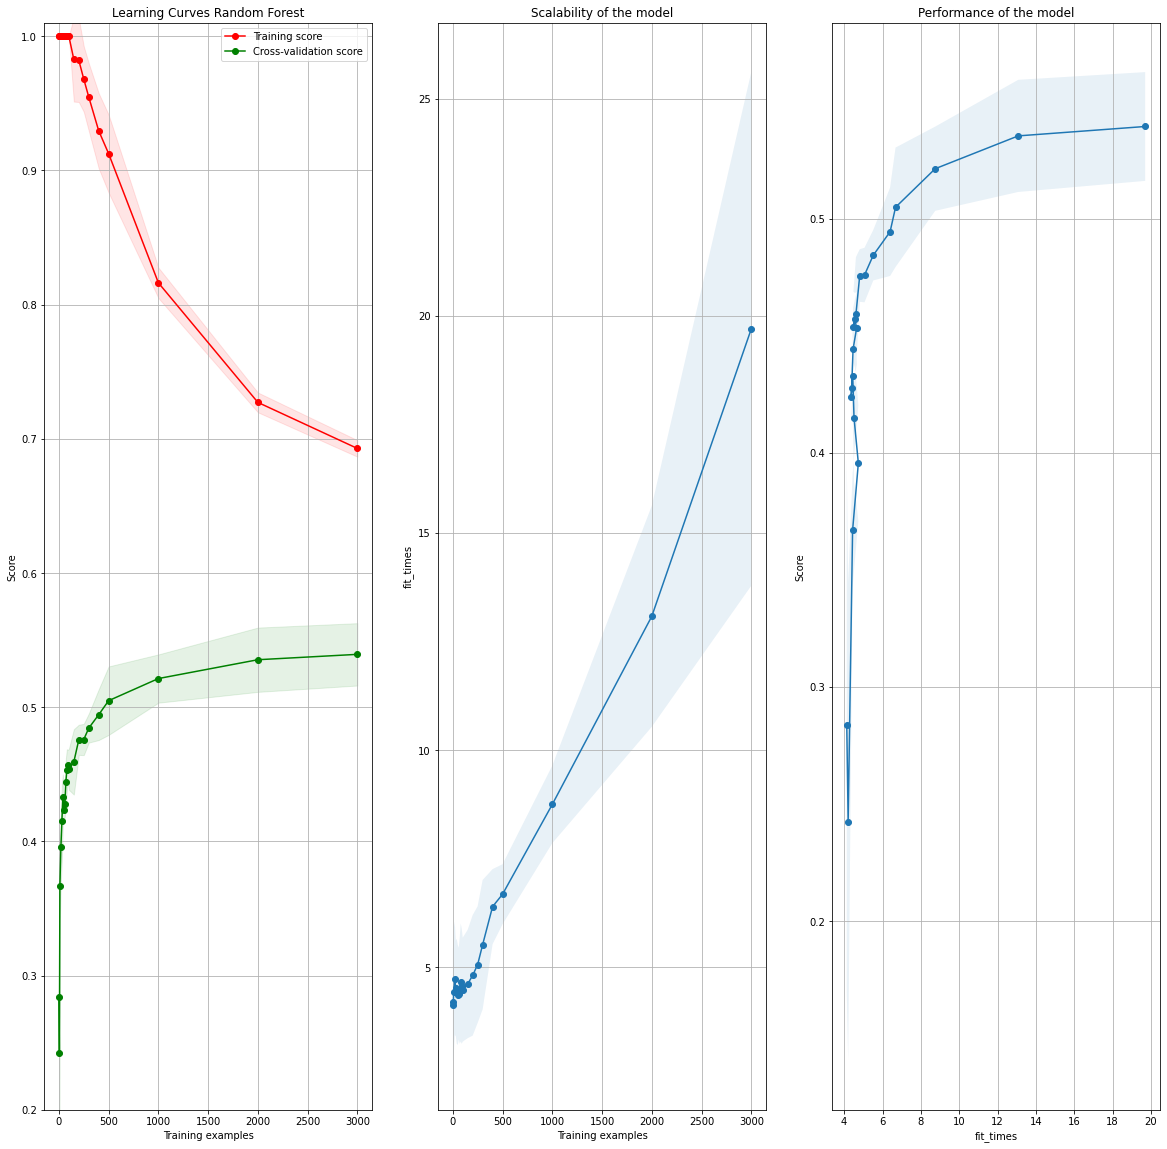

In [42]:
# INCREASE MAX DEPTH
train_sizes, train_scores, test_scores, fit_times, _  = learning_curve(
    estimator=RandomForestClassifier(n_estimators=500, max_depth=10, max_features=250, n_jobs=-1, oob_score=True, random_state=21),
    X=X_train,
    y=y_train,
    train_sizes=training_set_size,
    cv=5,
    shuffle=True,
    n_jobs=-1,
    random_state=21,
    return_times=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

# Plot learning curve
_, axes = plt.subplots(1, 3, figsize=(20, 20))

if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].set_title("Learning Curves Random Forest")
axes[0].set_ylim(*(0.20, 1.01))
axes[0].set_xlabel("Training examples")
axes[0].set_ylabel("Score")

axes[0].grid()
axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
axes[0].legend(loc="best")

# Plot n_samples vs fit_times
axes[1].grid()
axes[1].plot(train_sizes, fit_times_mean, 'o-')
axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                     fit_times_mean + fit_times_std, alpha=0.1)
axes[1].set_xlabel("Training examples")
axes[1].set_ylabel("fit_times")
axes[1].set_title("Scalability of the model")

# Plot fit_time vs score
axes[2].grid()
axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
axes[2].set_xlabel("fit_times")
axes[2].set_ylabel("Score")
axes[2].set_title("Performance of the model")

Text(0.5, 1.0, 'Performance of the model')

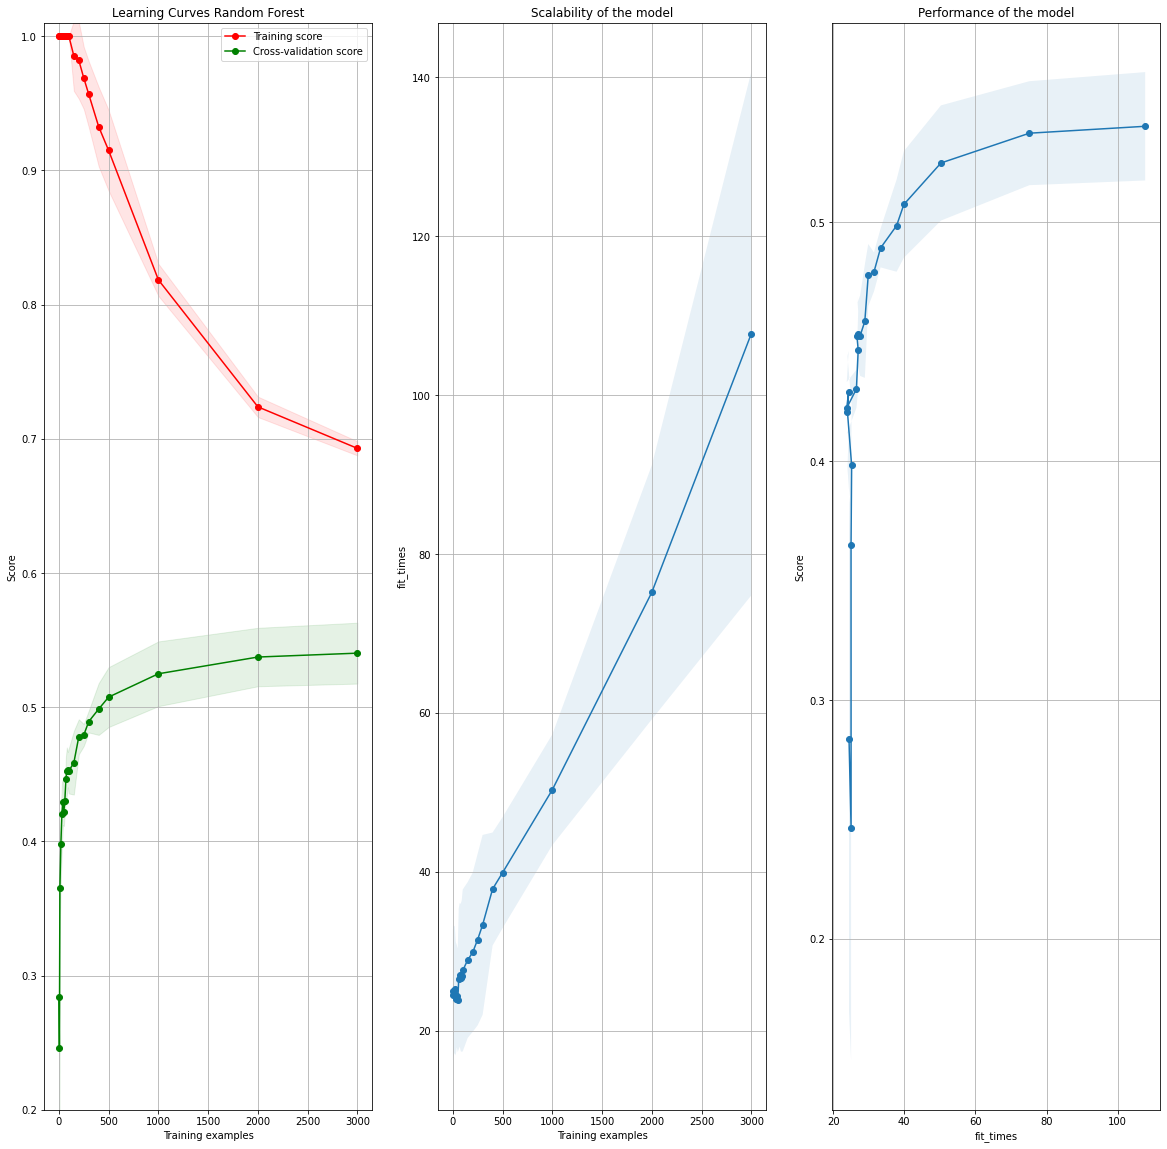

In [43]:
# INCREASE NUM ESTIMATORS
train_sizes, train_scores, test_scores, fit_times, _  = learning_curve(
    estimator=RandomForestClassifier(n_estimators=2500, max_depth=10, max_features=250, n_jobs=-1, oob_score=True, random_state=21),
    X=X_train,
    y=y_train,
    train_sizes=training_set_size,
    cv=5,
    shuffle=True,
    n_jobs=-1,
    random_state=21,
    return_times=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

# Plot learning curve
_, axes = plt.subplots(1, 3, figsize=(20, 20))

if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].set_title("Learning Curves Random Forest")
axes[0].set_ylim(*(0.20, 1.01))
axes[0].set_xlabel("Training examples")
axes[0].set_ylabel("Score")

axes[0].grid()
axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
axes[0].legend(loc="best")

# Plot n_samples vs fit_times
axes[1].grid()
axes[1].plot(train_sizes, fit_times_mean, 'o-')
axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                     fit_times_mean + fit_times_std, alpha=0.1)
axes[1].set_xlabel("Training examples")
axes[1].set_ylabel("fit_times")
axes[1].set_title("Scalability of the model")

# Plot fit_time vs score
axes[2].grid()
axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
axes[2].set_xlabel("fit_times")
axes[2].set_ylabel("Score")
axes[2].set_title("Performance of the model")

Text(0.5, 1.0, 'Performance of the model')

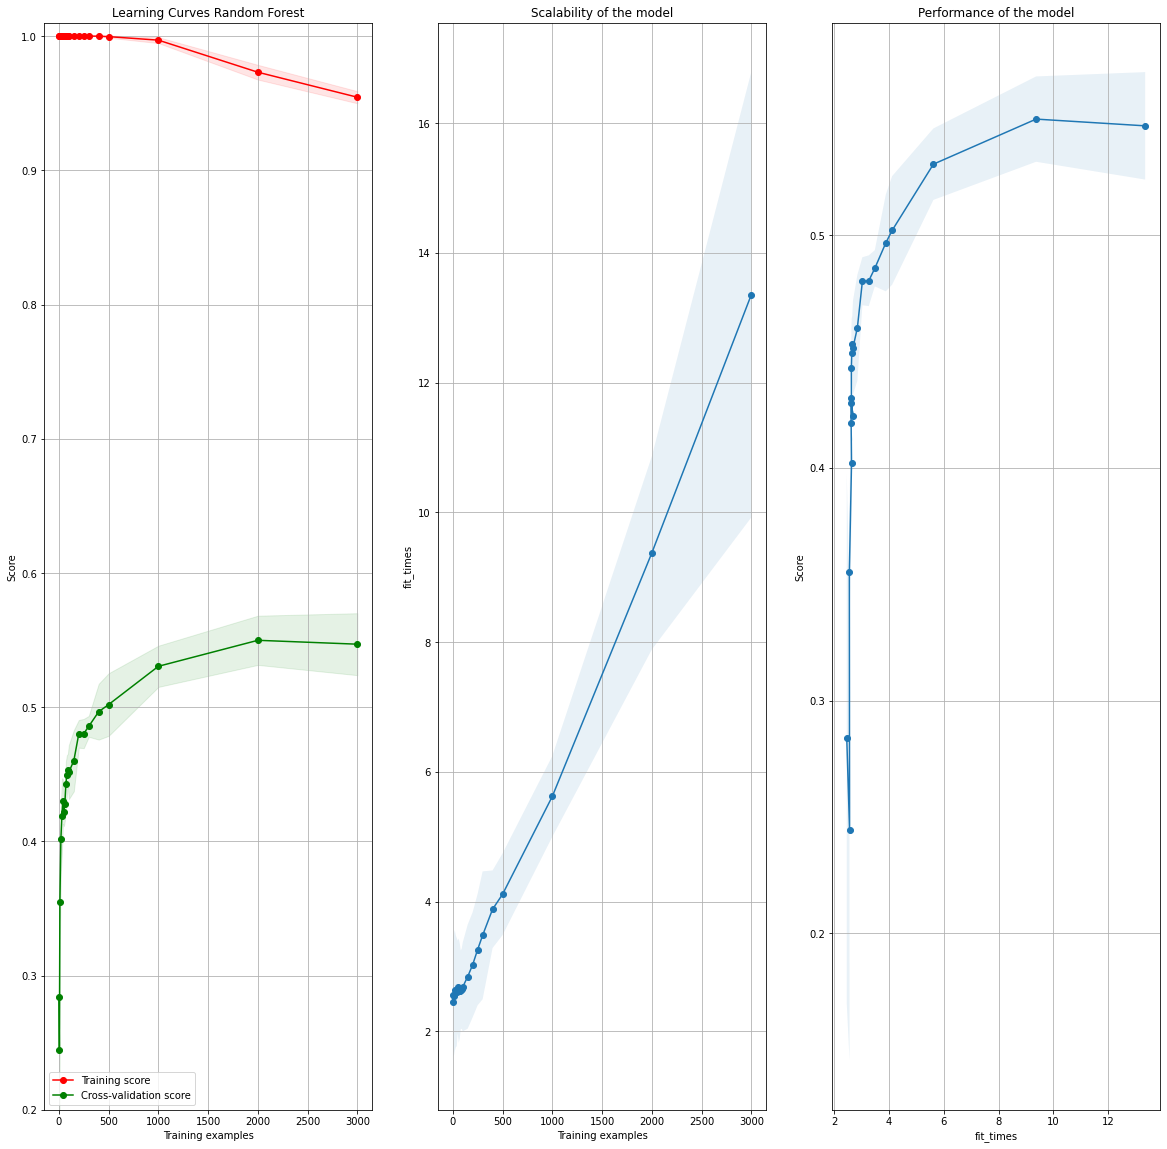

In [44]:
# INCREASE MAX DEPTH
train_sizes, train_scores, test_scores, fit_times, _  = learning_curve(
    estimator=RandomForestClassifier(n_estimators=250, max_depth=20, max_features=250, n_jobs=-1, oob_score=True, random_state=21),
    X=X_train,
    y=y_train,
    train_sizes=training_set_size,
    cv=5,
    shuffle=True,
    n_jobs=-1,
    random_state=21,
    return_times=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

# Plot learning curve
_, axes = plt.subplots(1, 3, figsize=(20, 20))

if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].set_title("Learning Curves Random Forest")
axes[0].set_ylim(*(0.20, 1.01))
axes[0].set_xlabel("Training examples")
axes[0].set_ylabel("Score")

axes[0].grid()
axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
axes[0].legend(loc="best")

# Plot n_samples vs fit_times
axes[1].grid()
axes[1].plot(train_sizes, fit_times_mean, 'o-')
axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                     fit_times_mean + fit_times_std, alpha=0.1)
axes[1].set_xlabel("Training examples")
axes[1].set_ylabel("fit_times")
axes[1].set_title("Scalability of the model")

# Plot fit_time vs score
axes[2].grid()
axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
axes[2].set_xlabel("fit_times")
axes[2].set_ylabel("Score")
axes[2].set_title("Performance of the model")

Text(0.5, 1.0, 'Performance of the model')

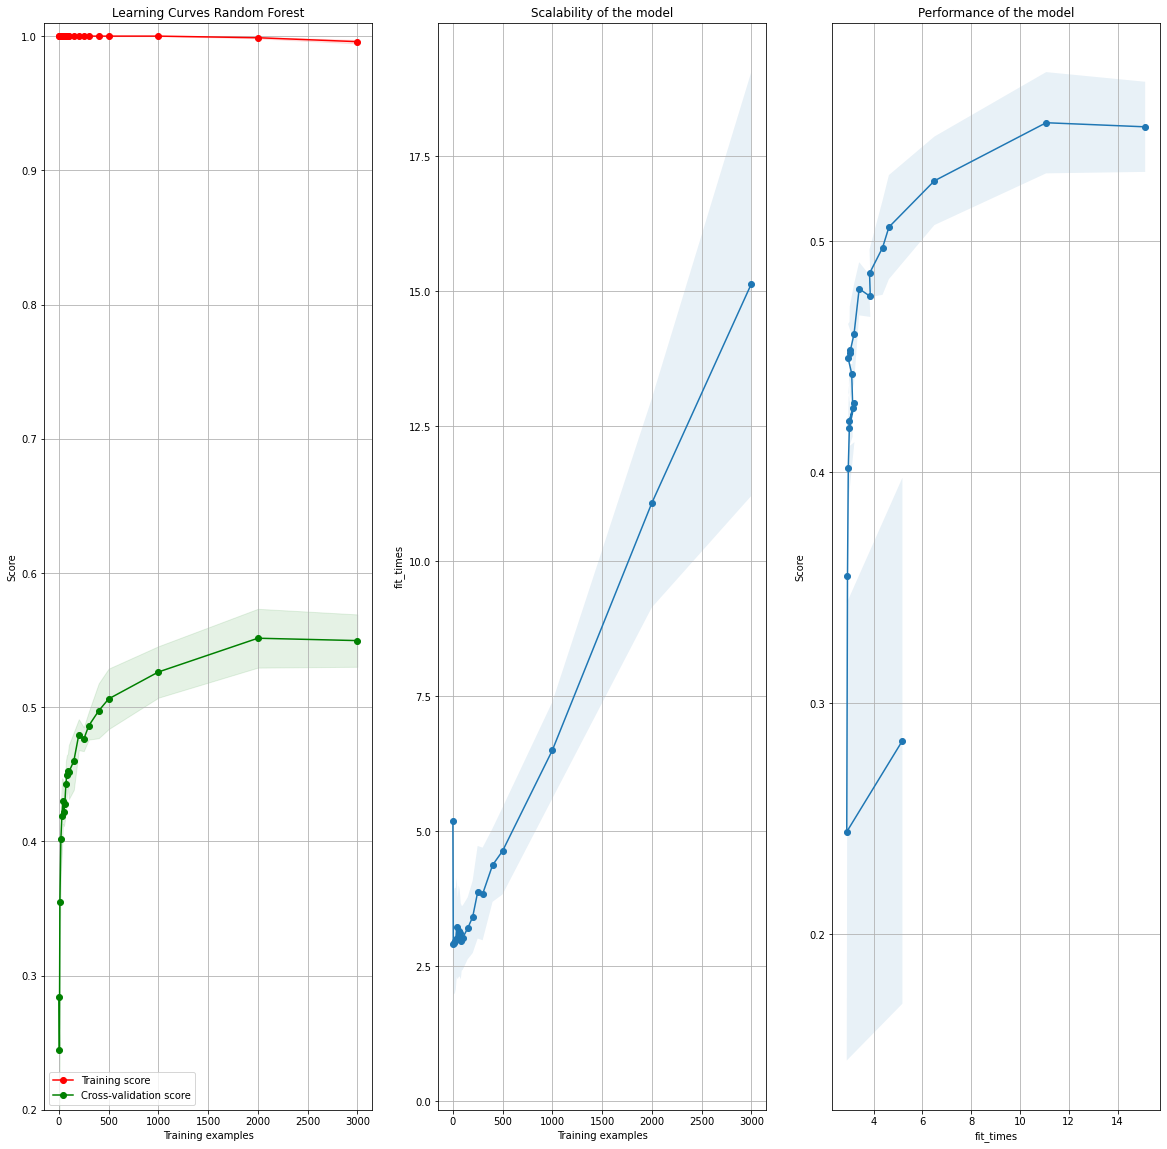

In [45]:
# INCREASE MAX DEPTH
train_sizes, train_scores, test_scores, fit_times, _  = learning_curve(
    estimator=RandomForestClassifier(n_estimators=250, max_depth=30, max_features=250, n_jobs=-1, oob_score=True, random_state=21),
    X=X_train,
    y=y_train,
    train_sizes=training_set_size,
    cv=5,
    shuffle=True,
    n_jobs=-1,
    random_state=21,
    return_times=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

# Plot learning curve
_, axes = plt.subplots(1, 3, figsize=(20, 20))

if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].set_title("Learning Curves Random Forest")
axes[0].set_ylim(*(0.20, 1.01))
axes[0].set_xlabel("Training examples")
axes[0].set_ylabel("Score")

axes[0].grid()
axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
axes[0].legend(loc="best")

# Plot n_samples vs fit_times
axes[1].grid()
axes[1].plot(train_sizes, fit_times_mean, 'o-')
axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                     fit_times_mean + fit_times_std, alpha=0.1)
axes[1].set_xlabel("Training examples")
axes[1].set_ylabel("fit_times")
axes[1].set_title("Scalability of the model")

# Plot fit_time vs score
axes[2].grid()
axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
axes[2].set_xlabel("fit_times")
axes[2].set_ylabel("Score")
axes[2].set_title("Performance of the model")

Text(0.5, 1.0, 'Performance of the model')

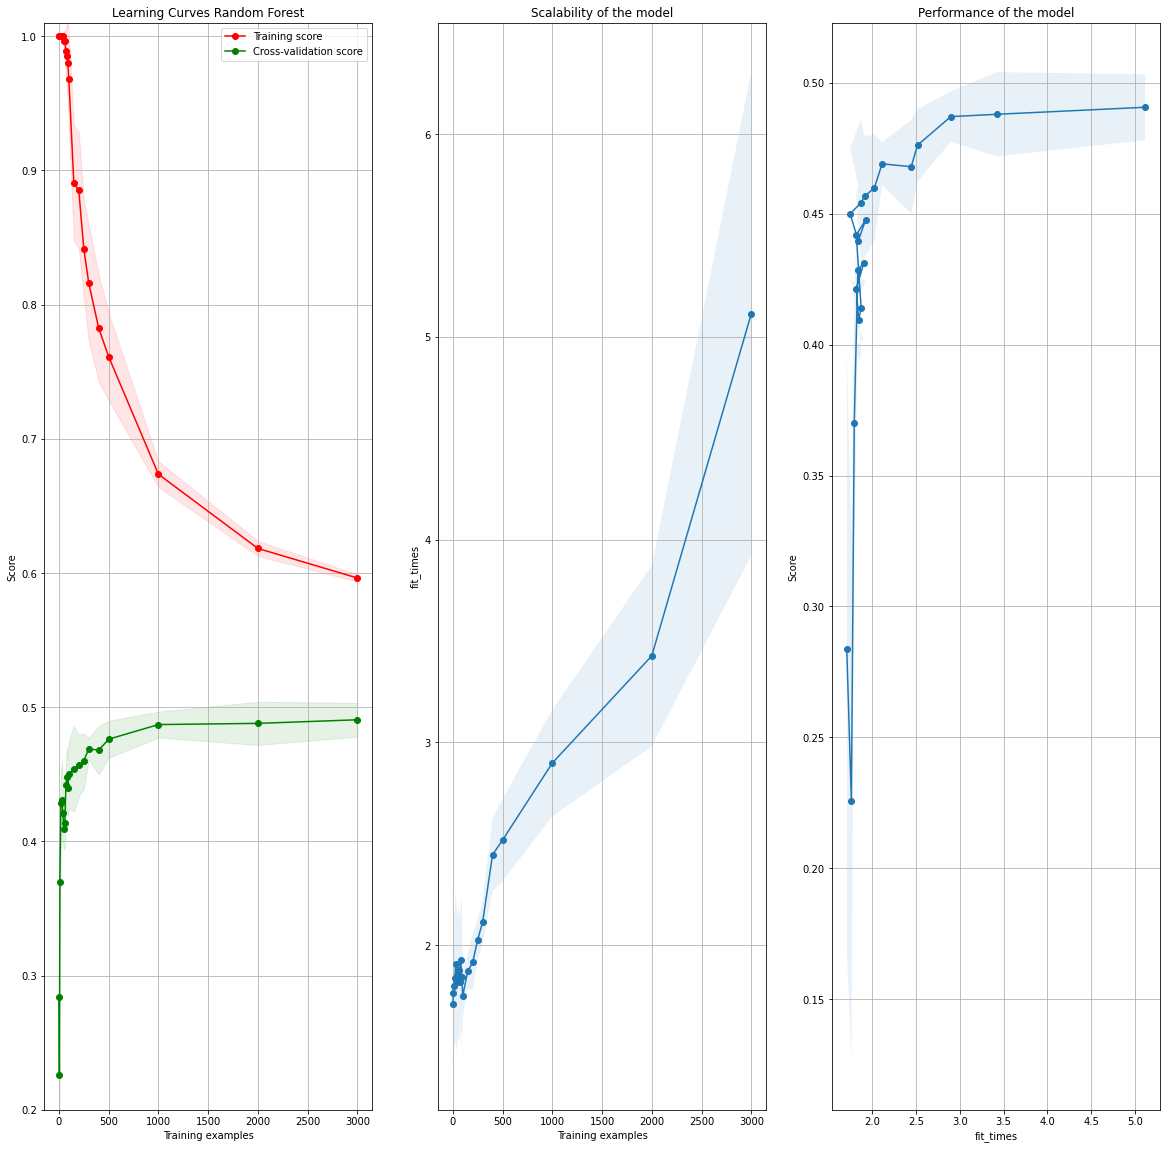

In [46]:
# Change max features
train_sizes, train_scores, test_scores, fit_times, _  = learning_curve(
    estimator=RandomForestClassifier(n_estimators=250, max_depth=10, max_features=30, n_jobs=-1, oob_score=True, random_state=21),
    X=X_train,
    y=y_train,
    train_sizes=training_set_size,
    cv=5,
    shuffle=True,
    n_jobs=-1,
    random_state=21,
    return_times=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

# Plot learning curve
_, axes = plt.subplots(1, 3, figsize=(20, 20))

if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].set_title("Learning Curves Random Forest")
axes[0].set_ylim(*(0.20, 1.01))
axes[0].set_xlabel("Training examples")
axes[0].set_ylabel("Score")

axes[0].grid()
axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
axes[0].legend(loc="best")

# Plot n_samples vs fit_times
axes[1].grid()
axes[1].plot(train_sizes, fit_times_mean, 'o-')
axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                     fit_times_mean + fit_times_std, alpha=0.1)
axes[1].set_xlabel("Training examples")
axes[1].set_ylabel("fit_times")
axes[1].set_title("Scalability of the model")

# Plot fit_time vs score
axes[2].grid()
axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
axes[2].set_xlabel("fit_times")
axes[2].set_ylabel("Score")
axes[2].set_title("Performance of the model")

## Predictions

In [47]:
# Randomly select 5 rows
import random

In [48]:
rnd = random.seed(22)
rand_idx = []
for _ in range(0, 5):
    rand_idx.append(random.randint(0, 4000))
    
rand_idx

[3924, 3716, 574, 993, 96]

In [49]:
text_x = []
for idx in rand_idx:
    text_x.append(df.iloc[idx]['blind_assessment'])
    
text_x

NameError: name 'df' is not defined

In [ ]:
matrix_x = t.texts_to_matrix(text_x, mode='count')
matrix_x

In [ ]:
exs_y = []
for idx in rand_idx:
    exs_y.append(y.cat.codes.iloc[idx])
exs_y

In [ ]:
rnd_clf.predict(matrix_x)

In [ ]:
y.cat.categories

## Test Set

In [50]:
# Final Model
rnd_clf = RandomForestClassifier(n_estimators=1000, max_depth=32, max_features=250, n_jobs=-1, oob_score=True, random_state=22)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=32, max_features=250, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=22)

In [53]:
from sklearn.metrics import accuracy_score
y_pred = rnd_clf.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))

Accuracy: 0.5280498664292075
